# Advanced Weather Data Analysis

This notebook performs advanced data analysis on a global weather dataset. The tasks include anomaly detection, forecasting with multiple models, and unique analyses like climate and environmental impact studies.

## Import Necessary Libraries

Import all required libraries upfront.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Load and Explore the Dataset

Loading the dataset and displaying the first few rows to understand its structure.


In [3]:
# Load the dataset
data = pd.read_csv("GlobalWeatherRepository.csv")

# Display the first few rows of the dataset
data.head()
data.isnull().sum()


country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

## Data Summary and Preliminary Visualizations

Provide a summary of the dataset and initial visualizations to understand the data distribution.


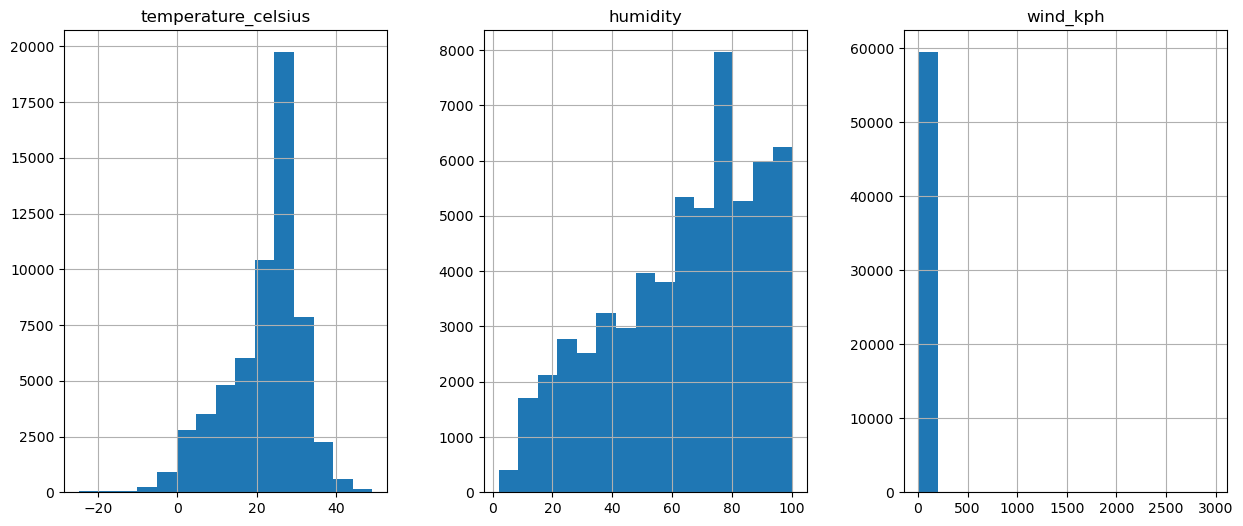

In [4]:
# Describe the data for an overview of statistical summaries

# Plot the distribution of key numerical features
numerical_features = ['temperature_celsius', 'humidity', 'wind_kph']
data[numerical_features].hist(bins=15, figsize=(15, 6), layout=(1, 3))
plt.show()


## Advanced EDA: Anomaly Detection

Implementing anomaly detection on temperature data using the Isolation Forest algorithm.


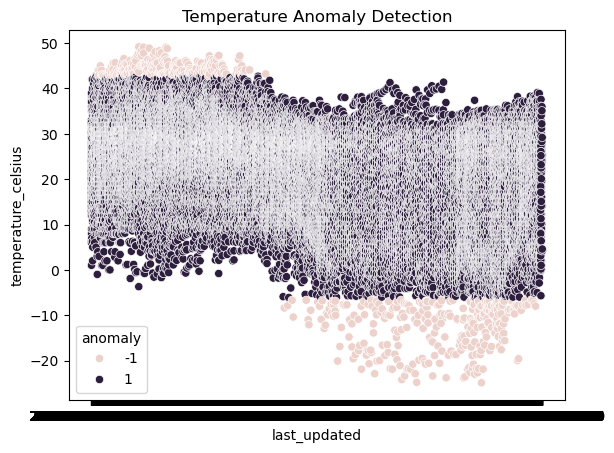

Number of anomalies detected: 581
Anomaly Temperature Statistics:
count    581.000000
mean      13.450775
std       28.613452
min      -24.900000
25%      -11.000000
50%       -6.900000
75%       44.100000
max       49.200000
Name: temperature_celsius, dtype: float64


In [5]:
# Anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.01)
data['anomaly'] = iso_forest.fit_predict(data[['temperature_celsius']])

# Visualizing anomalies in temperature
sns.scatterplot(data=data, x='last_updated', y='temperature_celsius', hue='anomaly')
plt.title('Temperature Anomaly Detection')
plt.show()

# Filter data for anomalies
anomalies = data[data['anomaly'] == -1]
# Remove anomalies
data = data[data['anomaly'] != -1]

# Proceed with your analysis using data_cleaned

# Display basic statistics and count of anomalies
print("Number of anomalies detected:", anomalies.shape[0])
print("Anomaly Temperature Statistics:")
print(anomalies['temperature_celsius'].describe())


## Forecasting with Multiple Models

Forecasting temperature using ARIMA and Prophet models and comparing their performance.


c:\Users\shiva\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shiva\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shiva\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing


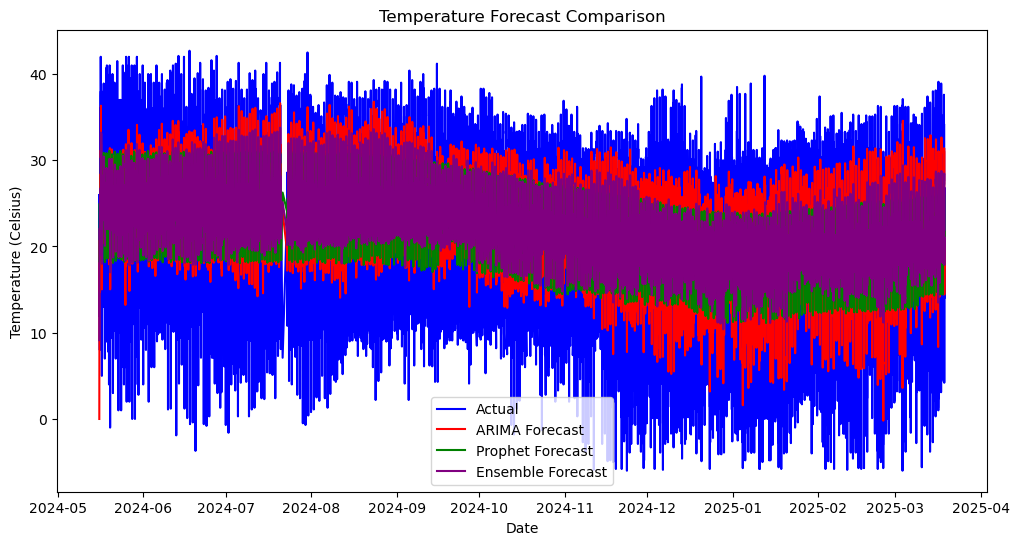

RMSE ARIMA:  9.414638194093449
RMSE Prophet:  8.474389781659811
RMSE Ensemble:  8.654260193567069


In [6]:
# Ensure data index is a datetime index and sorted
data['last_updated'] = pd.to_datetime(data['last_updated'])
data.set_index('last_updated', inplace=True)
data = data[~data.index.duplicated(keep='first')]  # Remove duplicates
data.sort_index(inplace=True)  # Sort the data by index

# ARIMA Forecast
arima_model = ARIMA(data['temperature_celsius'].dropna(), order=(5,1,0))
arima_result = arima_model.fit()
arima_predictions = arima_result.predict(start=data.index.min(), end=data.index.max(), typ='levels')

# Prophet Forecast
data_prophet = data.reset_index()[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
prophet_model = Prophet()
prophet_model.fit(data_prophet.dropna())
future = prophet_model.make_future_dataframe(periods=365, freq='D')
forecast_prophet = prophet_model.predict(future)
prophet_predictions = forecast_prophet.set_index('ds')['yhat'].reindex(data.index).interpolate()

# Ensemble Forecast
ensemble_predictions = (arima_predictions + prophet_predictions) / 2

# Function to calculate RMSE
def calculate_rmse(actual, predictions):
    combined = pd.concat([actual, predictions], axis=1).dropna()
    return np.sqrt(mean_squared_error(combined.iloc[:, 0], combined.iloc[:, 1]))

# Calculate RMSE
rmse_arima = calculate_rmse(data['temperature_celsius'], arima_predictions)
rmse_prophet = calculate_rmse(data['temperature_celsius'], prophet_predictions)
rmse_ensemble = calculate_rmse(data['temperature_celsius'], ensemble_predictions)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature_celsius'], label='Actual', color='blue')
plt.plot(arima_predictions.index, arima_predictions, label='ARIMA Forecast', color='red')
plt.plot(prophet_predictions.index, prophet_predictions, label='Prophet Forecast', color='green')
plt.plot(ensemble_predictions.index, ensemble_predictions, label='Ensemble Forecast', color='purple')
plt.legend()
plt.title('Temperature Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.show()

# Print RMSE results
print("RMSE ARIMA: ", rmse_arima)
print("RMSE Prophet: ", rmse_prophet)
print("RMSE Ensemble: ", rmse_ensemble)

## Unique Analyses

### Climate Analysis

Analyzing long-term climate patterns using historical temperature data.


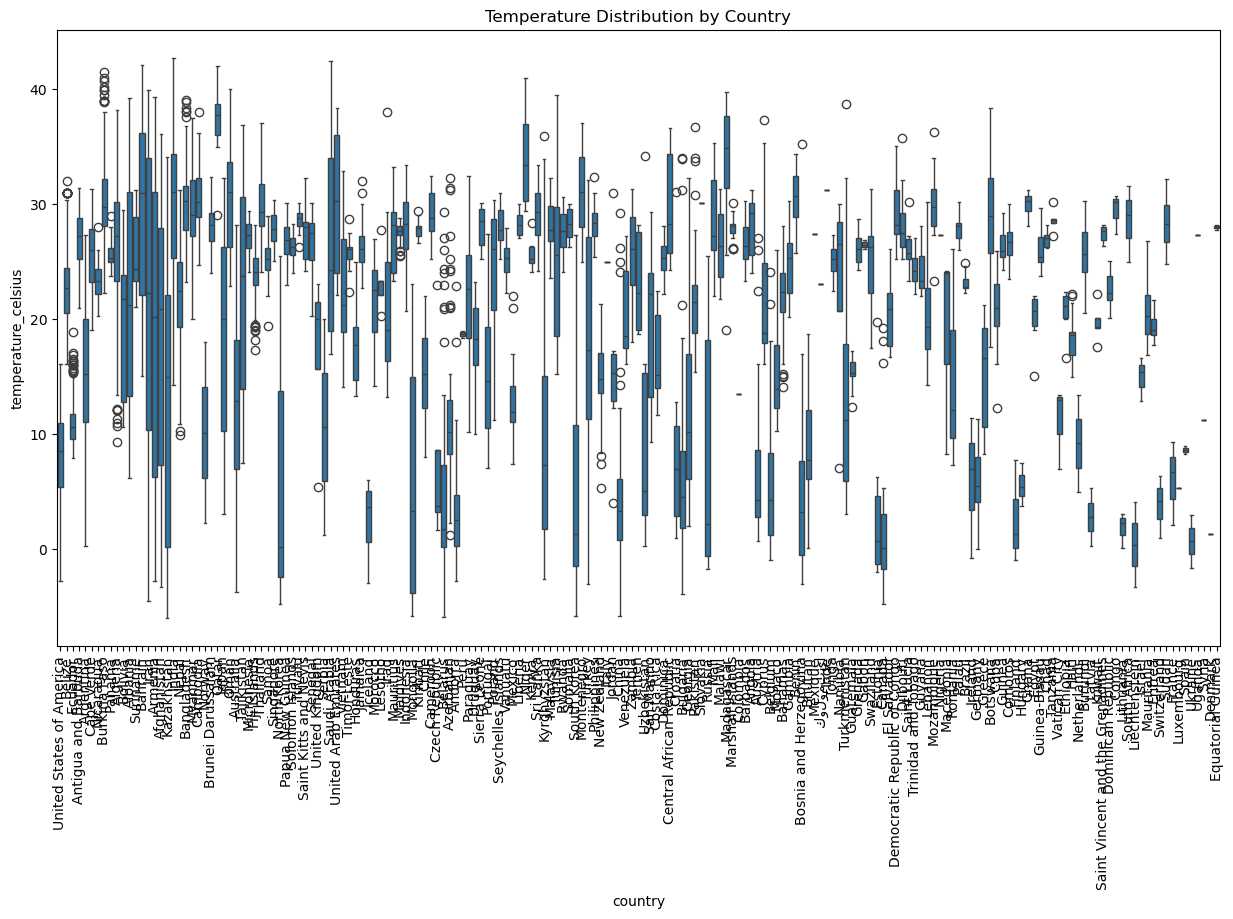

In [7]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='country', y='temperature_celsius', data=data)
plt.xticks(rotation=90)
plt.title('Temperature Distribution by Country')
plt.show()

### Environmental Impact Analysis

Analyzing the correlation between air quality indices and weather parameters.


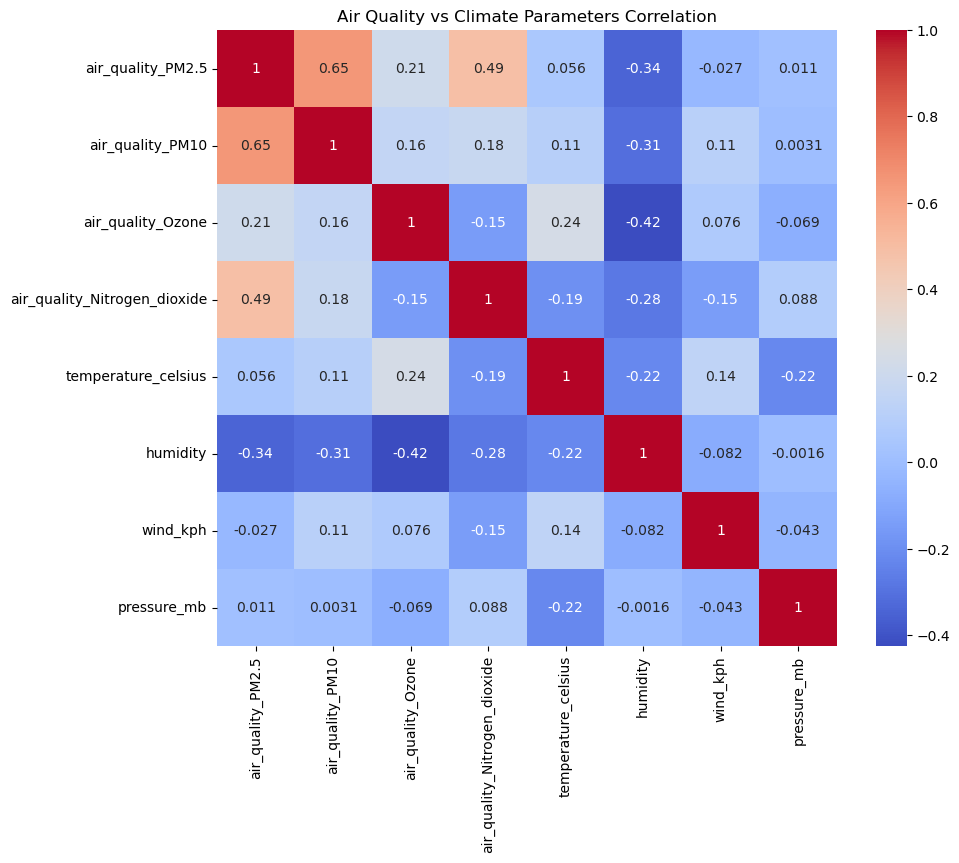

In [8]:
air_quality_cols = ['air_quality_PM2.5', 'air_quality_PM10',
                   'air_quality_Ozone', 'air_quality_Nitrogen_dioxide']
climate_cols = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb']

plt.figure(figsize=(10,8))
corr_matrix = data[air_quality_cols + climate_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Air Quality vs Climate Parameters Correlation')
plt.show()

### Feature Importance in Weather Prediction

Using Random Forest to identify important features affecting temperature.


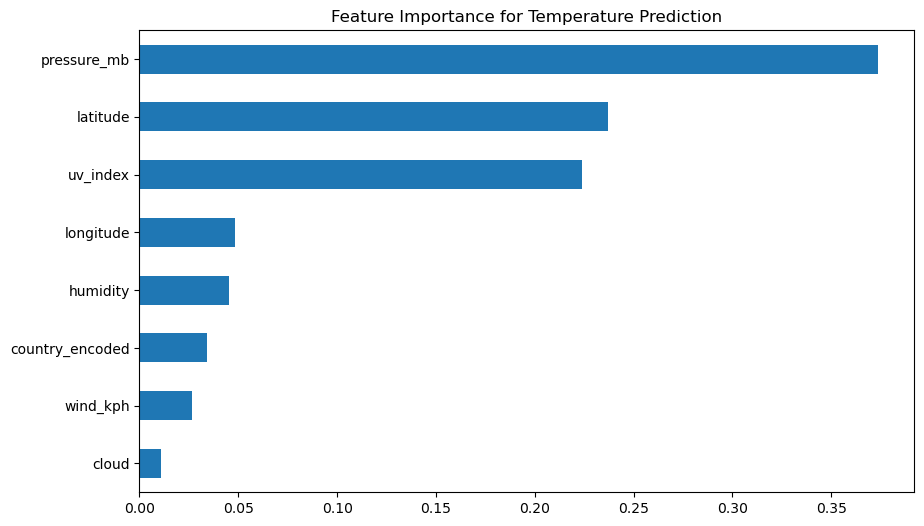

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['country_encoded'] = le.fit_transform(data['country'])
features = ['latitude', 'longitude', 'humidity', 'wind_kph', 'pressure_mb',
            'cloud', 'uv_index', 'country_encoded']
target = 'temperature_celsius'

# Train model
model = RandomForestRegressor()
model.fit(data[features], data[target])

# Plot feature importance
plt.figure(figsize=(10,6))
pd.Series(model.feature_importances_, index=features).sort_values().plot(kind='barh')
plt.title('Feature Importance for Temperature Prediction')
plt.show()

### Spatial Analysis of Weather Patterns

This analysis will visualize global temperature patterns using the GeoDataFrame.


In [13]:
!pip install cartopy

  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 330.3 kB/s eta 0:00:34
   ---------------------------------------- 0.0/11.0 MB 393.8 kB/s eta 0:00:28
   ---------------------------------------- 0.1/11.0 MB 901.1 kB/s eta 0:00:13
   -- ------------------------------------- 0.7/11.0 MB 3.6 MB/s eta 0:00:03
   ------- -------------------------------- 2.0/11.0 MB 9.0 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.0 MB 9.6 MB/s eta 0:00:01
   --------------- ------------------------ 4.2/11.0 MB 13.4 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/11.0 MB 15.2 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.0 MB 15.5 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 15.6 MB/s eta 0:00:01
   ------------

c:\Users\shiva\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


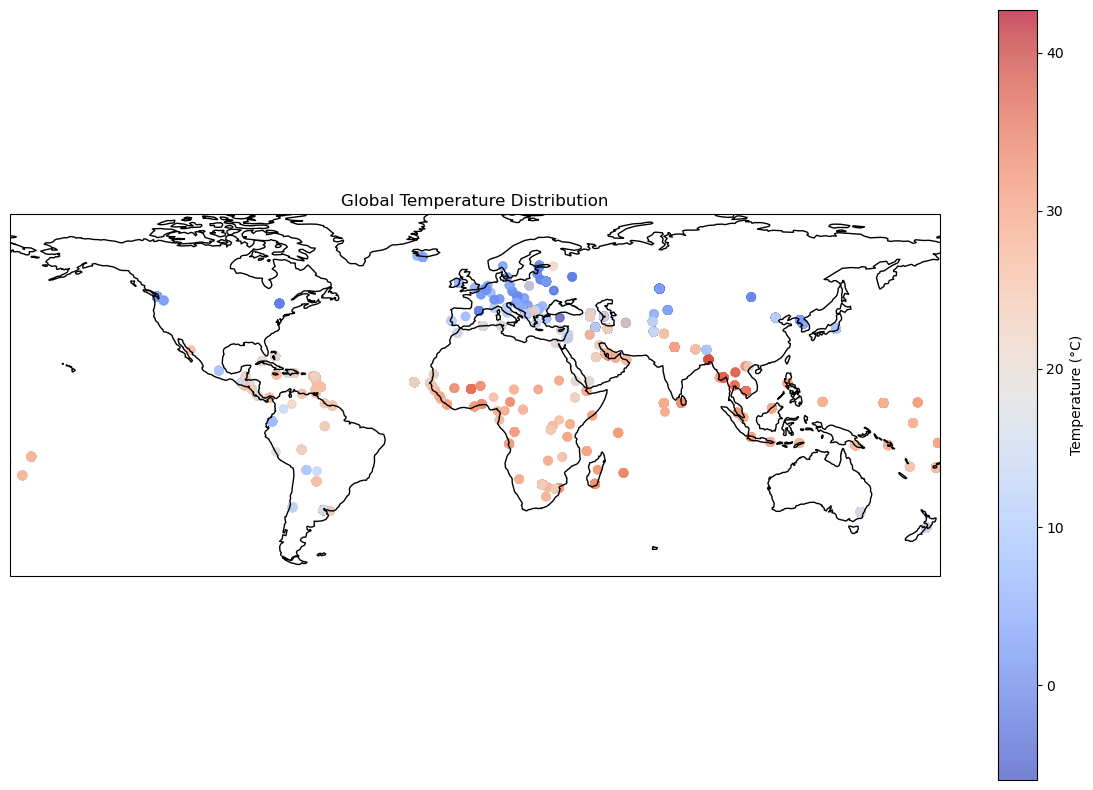

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.set_extent([-180, 180, -60, 80])

scatter = ax.scatter(data['longitude'], data['latitude'], c=data['temperature_celsius'],
                     cmap='coolwarm', alpha=0.7, transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Temperature (°C)')
# Visulaize

plt.title('Global Temperature Distribution')
plt.show()


###  Geographical Patterns: Temperature Differences by Continent

This analysis will aggregate temperature data by continent and visualize these differences.

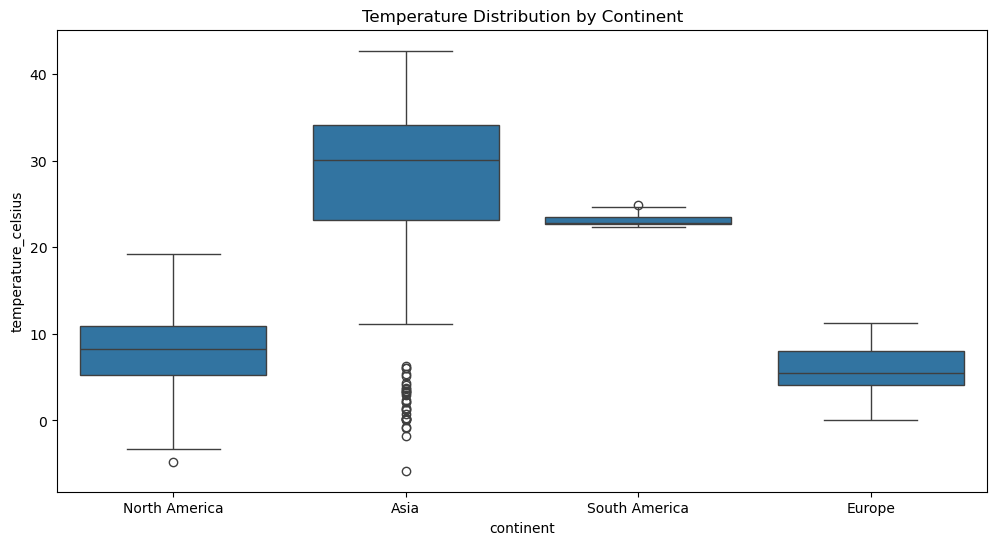

In [15]:
continent_map = {
    'United States of America': 'North America',
    'Canada': 'North America',
    'Brazil': 'South America',
    'China': 'Asia',
    'India': 'Asia',
    'Germany': 'Europe',
}
# Plot

data['continent'] = data['country'].map(continent_map)

plt.figure(figsize=(12,6))
sns.boxplot(x='continent', y='temperature_celsius', data=data)
plt.title('Temperature Distribution by Continent')
plt.show()